## Create Graph Plots of the Vector Images in Tempest

In [1]:
from itertools import groupby
from operator import itemgetter
from matplotlib import pyplot as plt
import os

plt.style.use('dark_background')
plt.rcParams['figure.dpi'] = 150

colors = {
    "TURQOI":"CYAN",
    "PDIWHI":"WHITE",
    "PDIRED":"RED",
    "PDIYEL":"YELLOW",
    "":"WHITE",
}

def scvec(old_x,old_y,color,x,y,i=0):
    c = "BLACK" if i == 0 else colors.get(color,color)
    vec=(x-old_x,y-old_y,c)
    old_x = x
    old_y = y
    return (vec,old_x,old_y)

def calvec(old_x,old_y,x,y,CALBRITE):
    vec=(x-old_x,y-old_y,CALBRITE)
    old_x = x
    old_y = y
    return (vec,old_x,old_y)

def vctr(color,x,y,i=""):
    x,y=int(x,16),int(y,16)
    if i == "0":
        return (x,y,"BLACK")
    return (x,y,colors.get(color,color))

def parse_calvec_parms(parms):
    x,y = [x.replace('.','') for x in parms[0].split(',')]
    x = 0x00 if x == "NXE" else int(x,16)
    y = int(y,16)
    return (x,y)

def parse_vector_commands(vector_data,default_color="red"):
    # Read in the vector commands from the Tempest source code
    # and translate them into a series of vectors, i.e. a  list of 
    # tuples of the form (x,y,color).
    # This list can then be transformed into a series of x,y co-ordinates
    # for plotting on a graph.
    color = ""
    vecs = []
    old_x,old_y = 0,0
    CALBRITE = "BLACK"
    for l in vector_data.splitlines():
        if not l.strip():
            continue
        tokens = l.strip().split()
        cmd, parms = tokens[0],tokens[1:]
        if cmd in ["ICVEC","ICALVE"]:
            vecs+=[(0,0,"BLACK")]
            old_x,old_y=0,0
        elif cmd == "CNTR":
            vecs+=[(0,0,"BLACK")]
        elif cmd == "CSTAT":
            color = parms[0]
        elif cmd == "VCTR":
            parms = parms[0].split(',')
            vecs+=[vctr(color,*parms)]
        elif cmd == "VEC":
            # A 0,0 origin is implicit.
            if len(vecs) == 0:
                vecs+=[(0,0,default_color)]    
            parms = parms[0].split(',')
            vecs+=[vctr(default_color,*parms)]
        elif cmd == "SCVEC":
            parms = [int(x.replace('.',''),16) for x in parms[0].split(',')]
            vec,old_x,old_y = scvec(old_x,old_y,color,*parms)
            vecs+=[vec]
        elif cmd == "VDOT":
            # VCTR
            vecs+=[vctr(color,"0","0","CB")]
        elif cmd == "SCDOT":
            # SCVEC
            parms = [int(x.replace('.',''),16) for x in parms[0].split(',')]
            vec,old_x,old_y = scvec(old_x,old_y,color,*parms)
            vecs+=[vec]
            # VCTR
            vecs+=[vctr(color,"0","0","CB")]
        elif cmd in [".BRITE=VARBRT",".BRITE =VARBRT"]:
            CALBRITE=default_color
        elif cmd in [".BRITE=0",".BRITE =0"]:
            CALBRITE="BLACK"
        elif cmd == "CALVEC":
            x,y = parse_calvec_parms(parms)
            vec,old_x,old_y = calvec(old_x,old_y,x,y,CALBRITE)
            vecs+=[vec]
    return vecs

def vectors_to_coords(vectors):
    # Turns a series of vectors into a series of x,y co-ordinates
    # or vertices.
    xs,ys,cs=[],[],[]
    px,py,pc=0,0,None
    for x,y,c in vectors:
        # If we're changing color, add a vertex with the
        # new color at the old position.
        if pc and c != pc:
            xs+=[px]
            ys+=[py]
            cs+=[c]
        # Calculate the position of the new vertex
        px+=x
        py+=y
        xs+=[px]
        ys+=[py]
        cs+=[c]
        pc=c
    return list(zip(xs,ys,cs))

def plot_vertices(verts,points="",linewidth=3.0):
    # Plot a series of vertices onto a graph. In other words,
    # create an image from them.
    _, ax = plt.subplots()
    last_x,last_y=[],[]
    for k,g in groupby(verts, key=itemgetter(2)):
        l = list(g)
        xs,ys,_ =zip(*l)
        # Don't paint the vectors marked as black, 
        # we're just moving the beam.
        alpha = 0 if k == "BLACK" else 1
        ax.plot(xs,ys,points+'-',color=k,alpha=alpha,linewidth=linewidth)

def tabulateVecsAndVerts(vectors,vertices):
    data =[["Vector X", "Vector Y", "Vertex X", "Vertex Y"]]
    for (vx,vy,_),(x,y,_) in zip(vectors,vertices):
        data +=[[str(vx),str(vy),str(x),str(y),]]
    table = tabulate.tabulate(data, tablefmt='html')
    return table

## Show How The Cursor is Built up From Vectors

[(0, 0, 'red'), (4, 1, 'red'), (4, -1, 'red'), (-2, 1, 'red'), (1, 1, 'red'), (-3, -1, 'red'), (-3, 1, 'red'), (1, -1, 'red'), (-2, -1, 'red')]


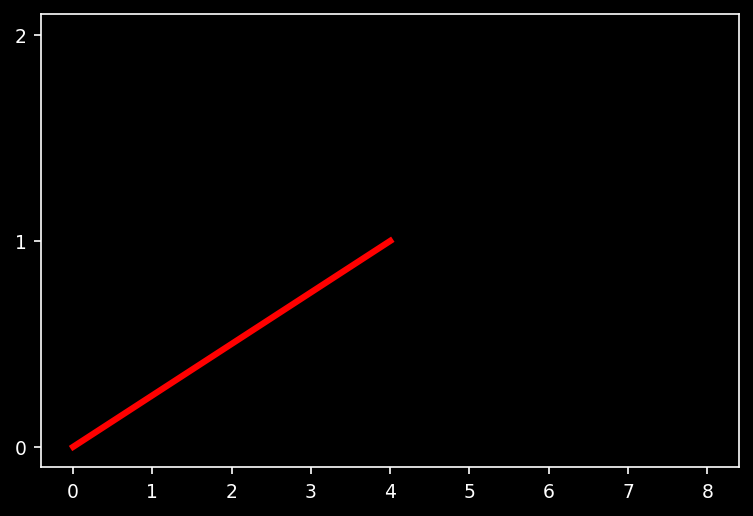

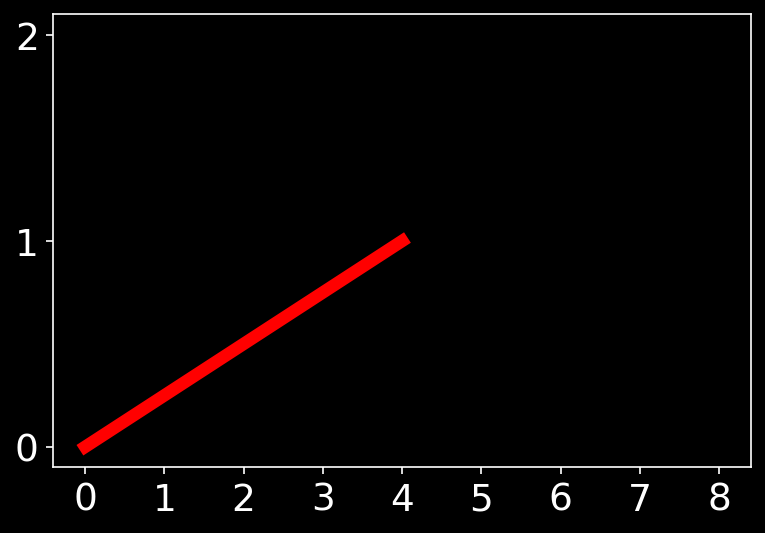

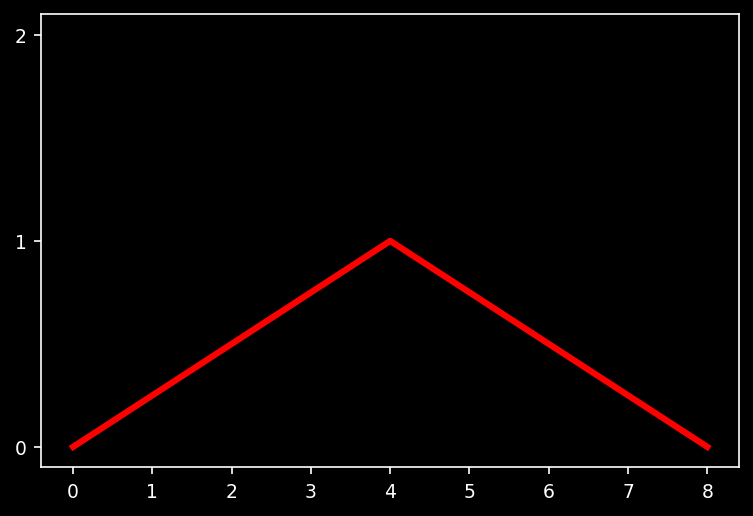

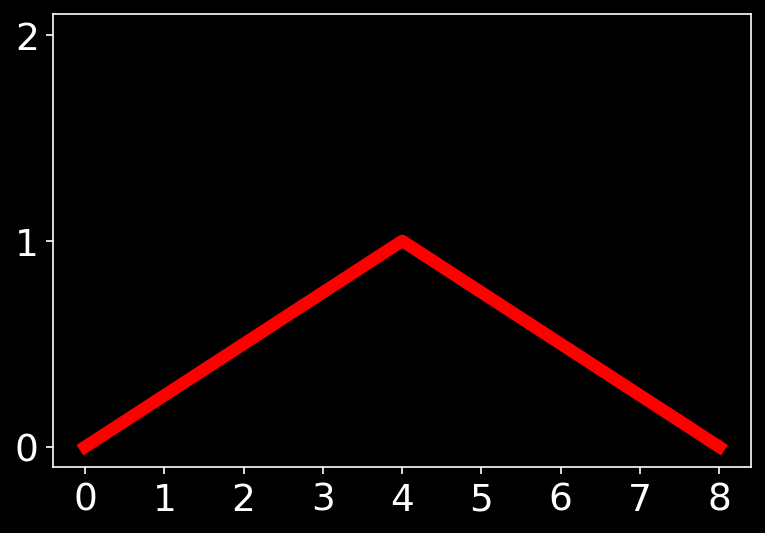

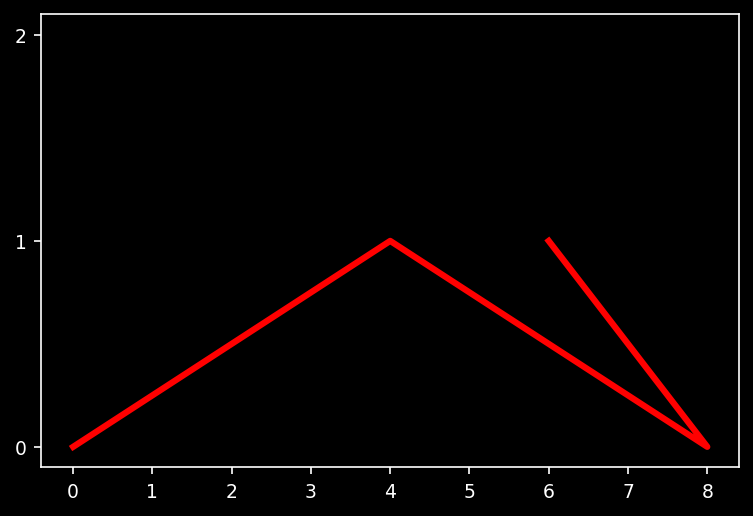

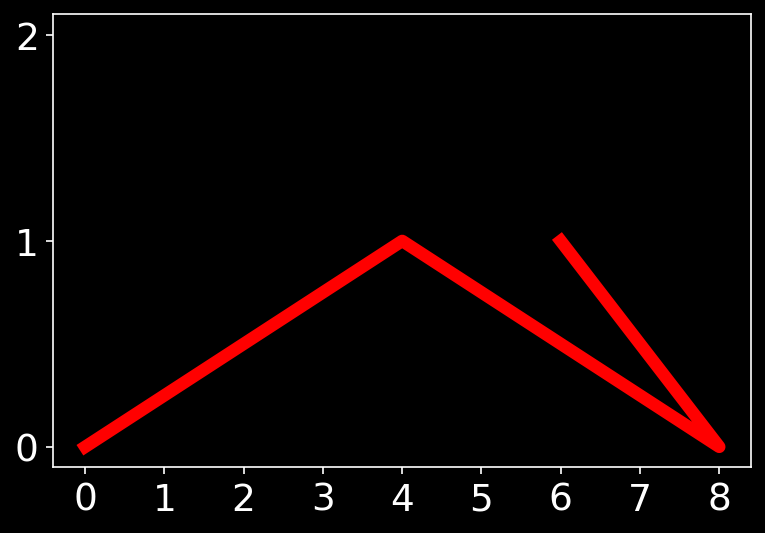

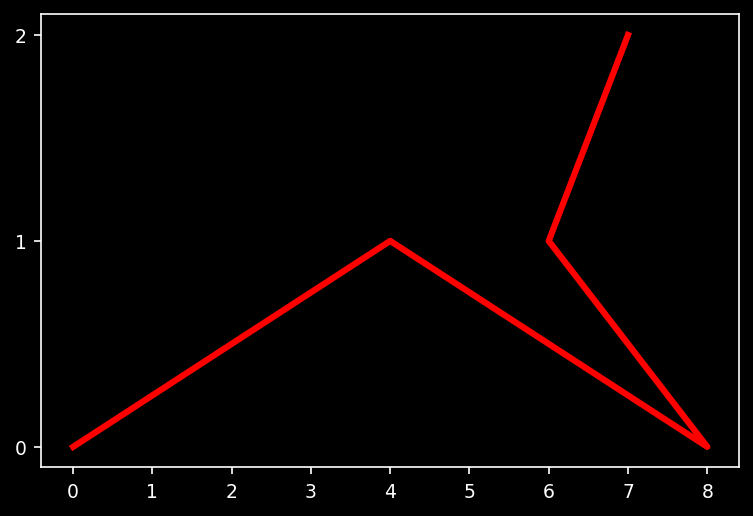

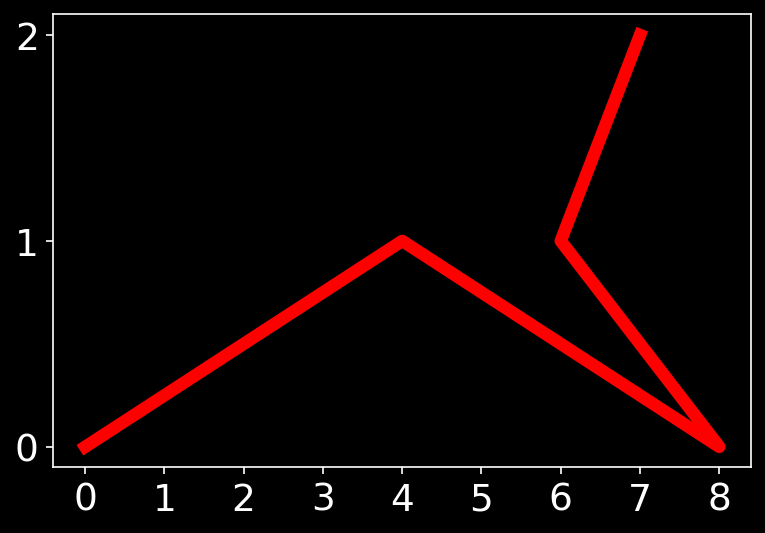

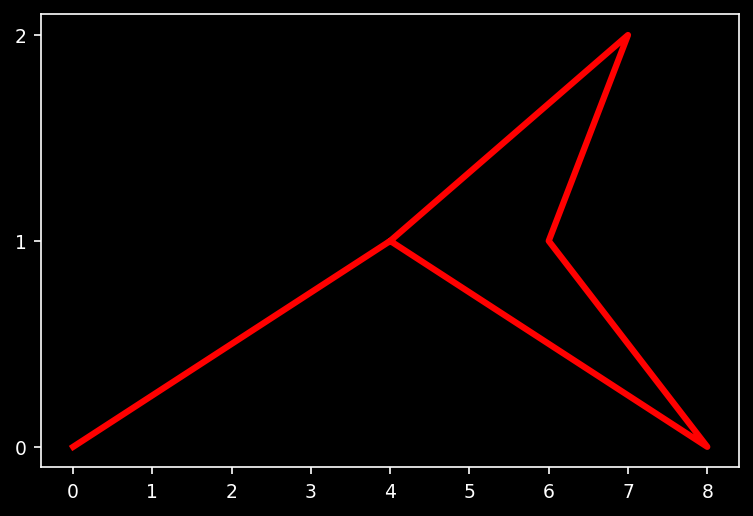

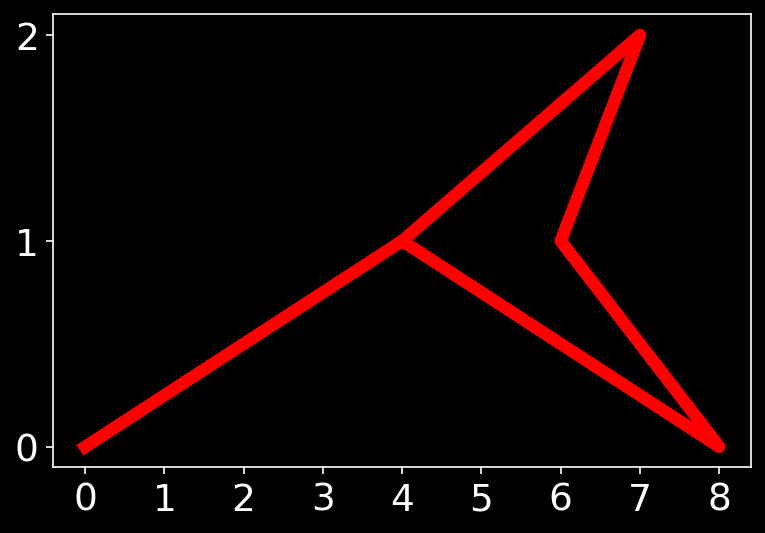

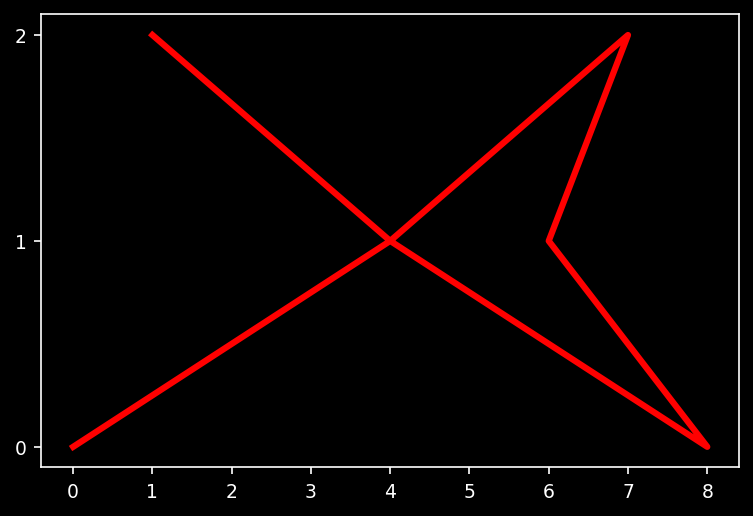

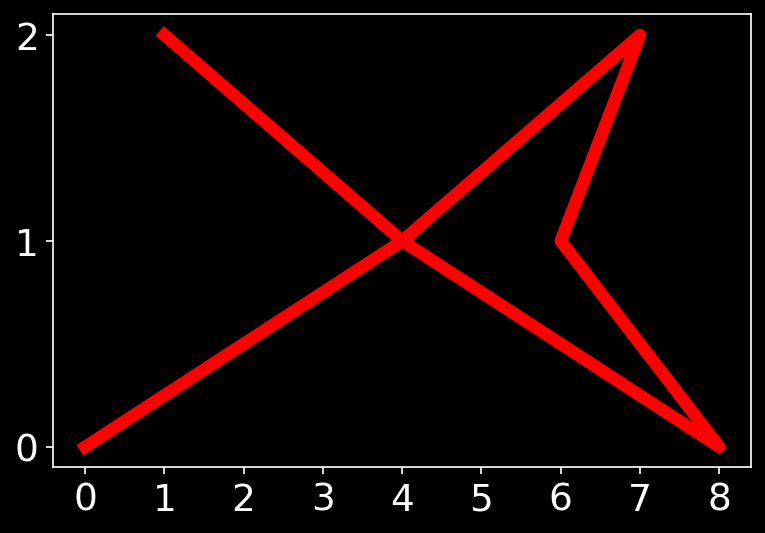

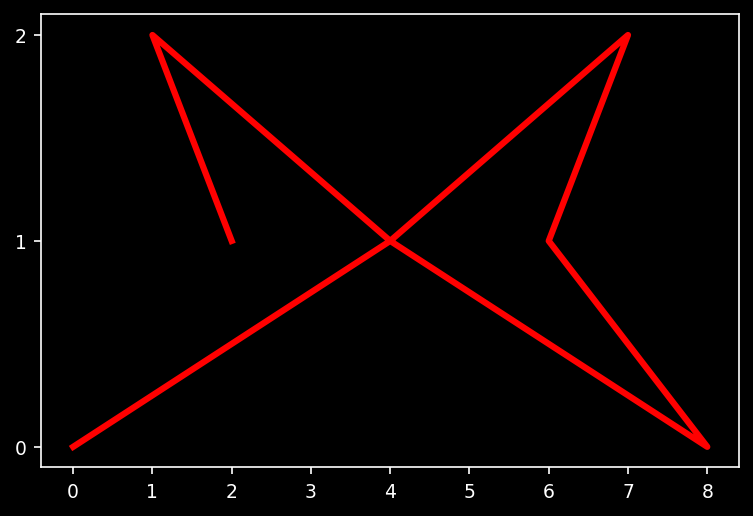

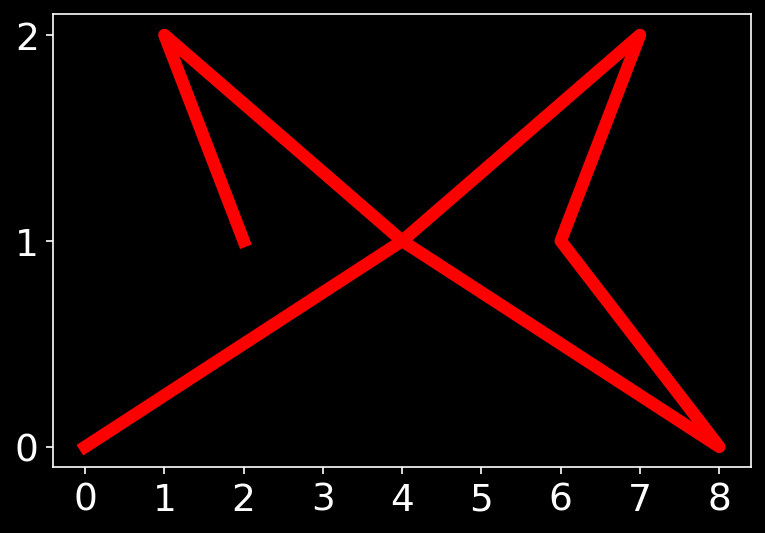

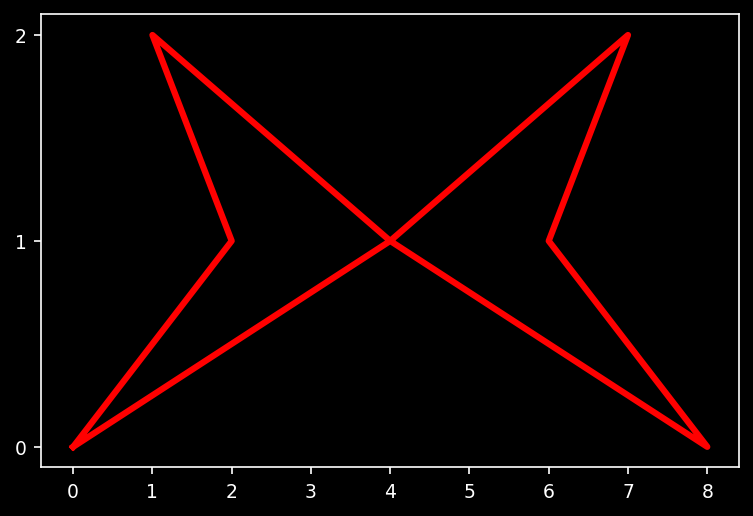

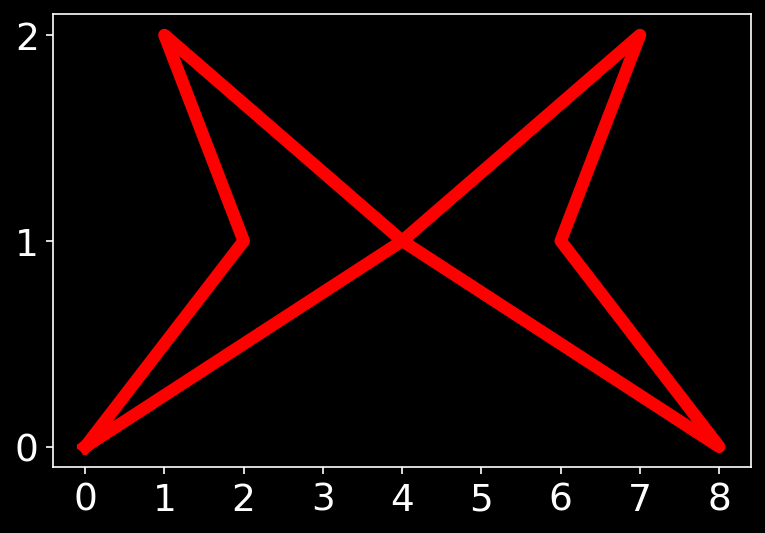

In [6]:
plt.style.use('dark_background')
plt.rcParams['figure.dpi'] = 150

def plot_gradual_vertices(verts,mins_maxes,file_name_suffix,linewidth=6.0,points=""):
    # Plot a series of vertices onto a graph. In other words,
    # create an image from them.
    _, ax = plt.subplots()
    min_x,max_x,min_y,max_y = mins_maxes
    last_x,last_y=[],[]
    for k,g in groupby(verts, key=itemgetter(2)):
        l = list(g)
        xs,ys,_ =zip(*l)
        # Don't paint the vectors marked as black, 
        # we're just moving the beam.
        alpha = 0 if k == "BLACK" else 1
        ax.plot(xs,ys,points+'-',color=k,alpha=alpha,linewidth=linewidth)
    ax.dataLim.y0 = min_y
    ax.dataLim.y1 = max_y
    ax.dataLim.x0 = min_x
    ax.dataLim.x1 = max_x
    ax.set_yticks([2,1,0])
    ax.set_xticks(range(0,9))
    ax.tick_params(axis='both', which='major', labelsize=linewidth*3)
    plt.savefig(f"flippers/build_flipper_{file_name_suffix}.png", bbox_inches='tight')

vector_data = """
INVA1S:
	VEC 4,1,1
	VEC 4,-1,1
	VEC -2,1
	VEC 1,1
	VEC -3,-1
	VEC -3,1
	VEC 1,-1
	VEC -2,-1
"""
vectors = parse_vector_commands(vector_data,default_color="red")
print(vectors)
vertices = vectors_to_coords(vectors)
max_x = max([x for x,_,_ in vertices])
min_x = min([x for x,_,_ in vertices])
max_y = max([y for _,y,_ in vertices])
min_y = min([y for _,y,_ in vertices])
mins_maxes = (min_x,max_x,min_y,max_y)

for i in range(2,len(vertices)+1):
    for lw in [3,6]:
        plot_gradual_vertices(vertices[:i],mins_maxes,f"{i}_{lw}",lw)


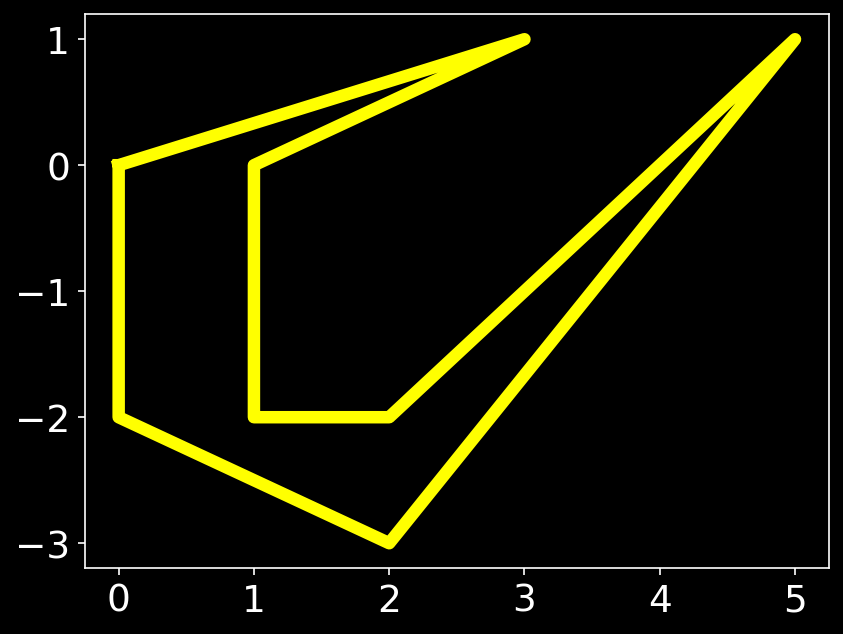

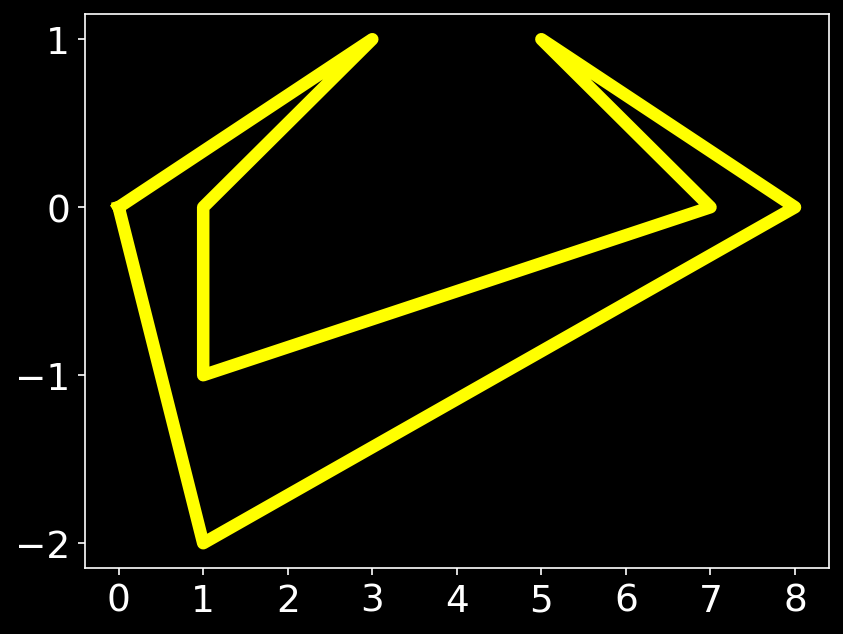

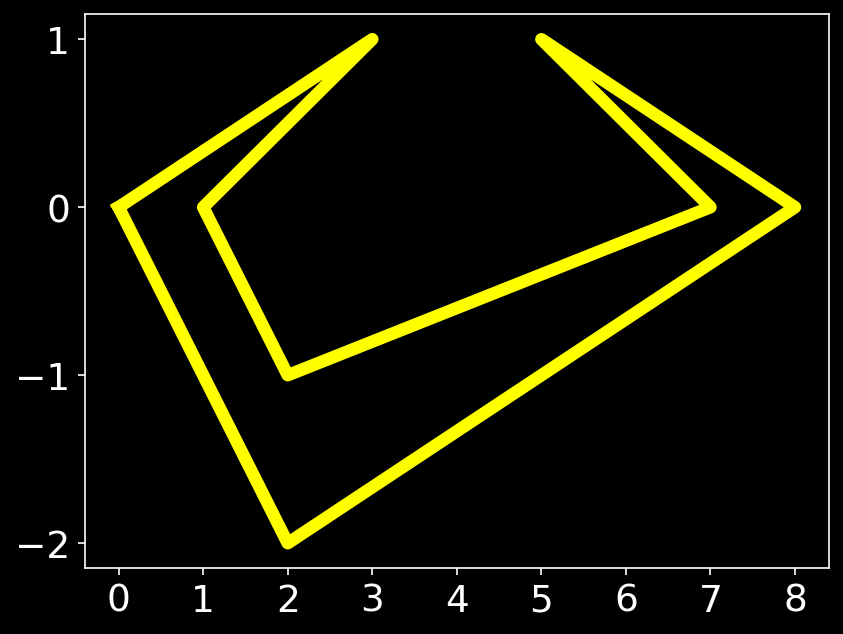

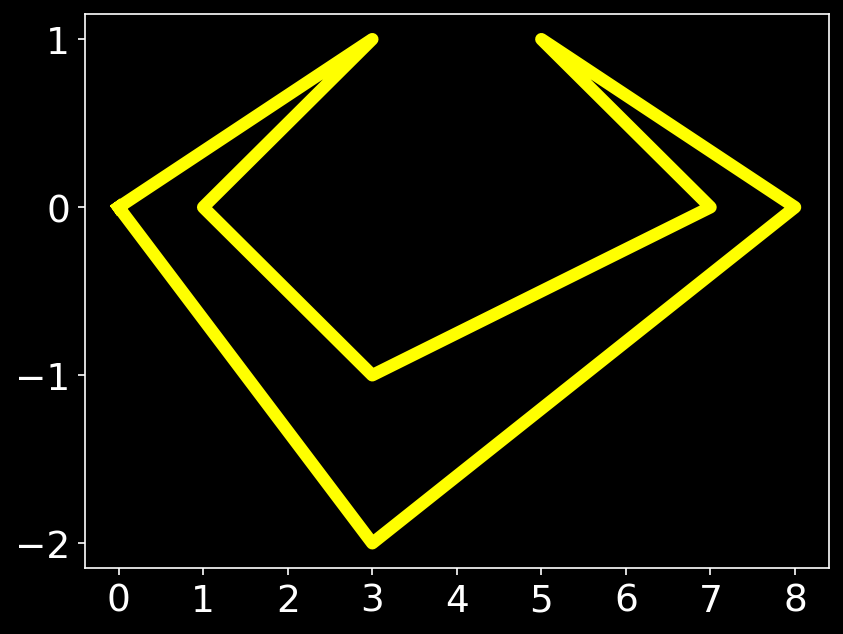

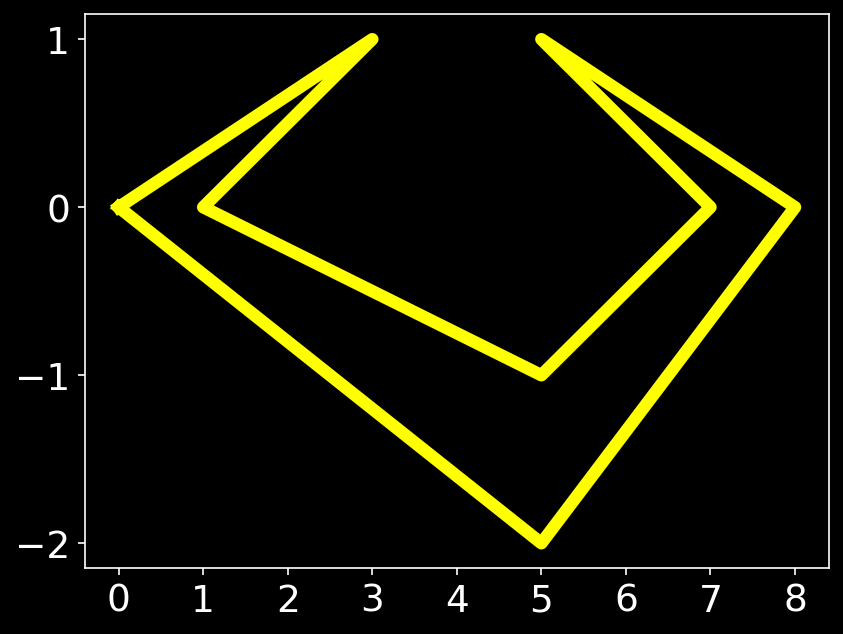

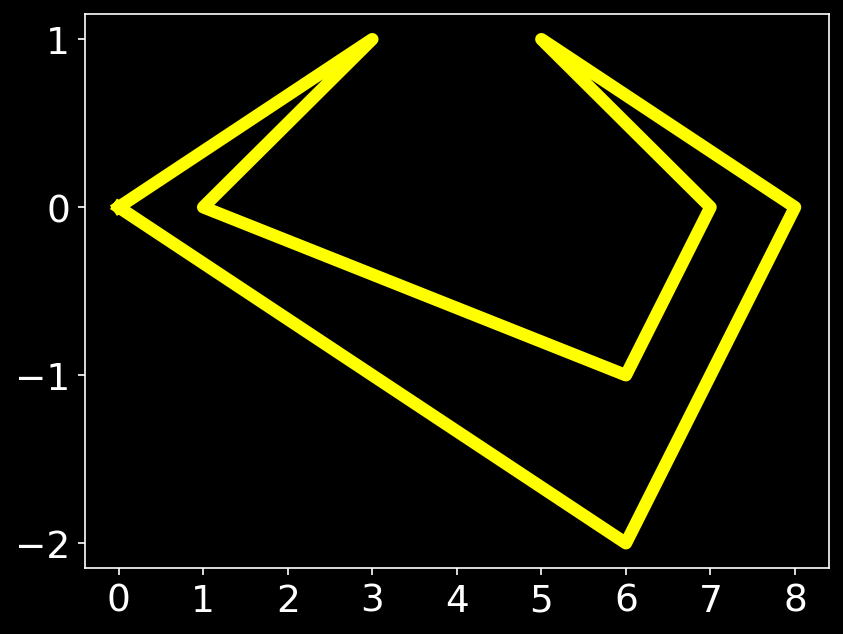

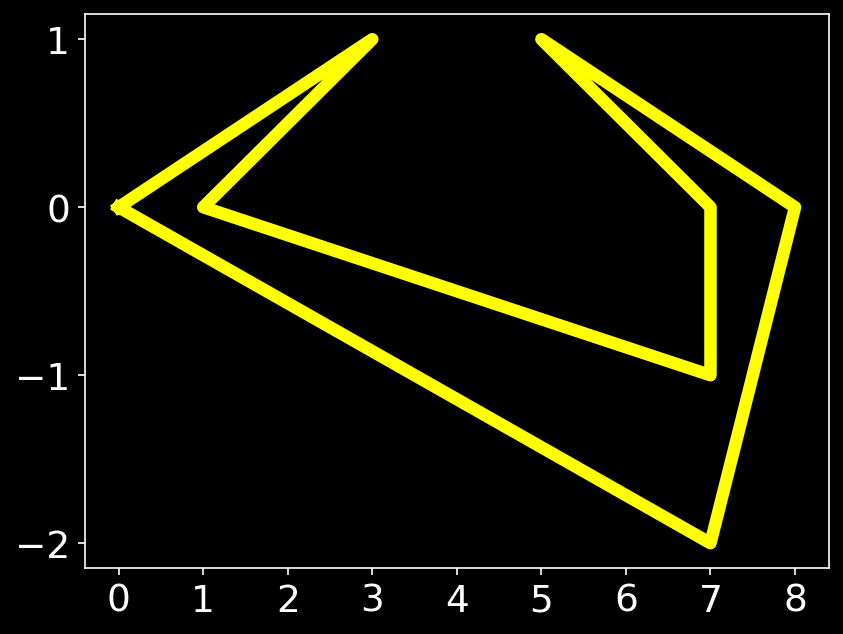

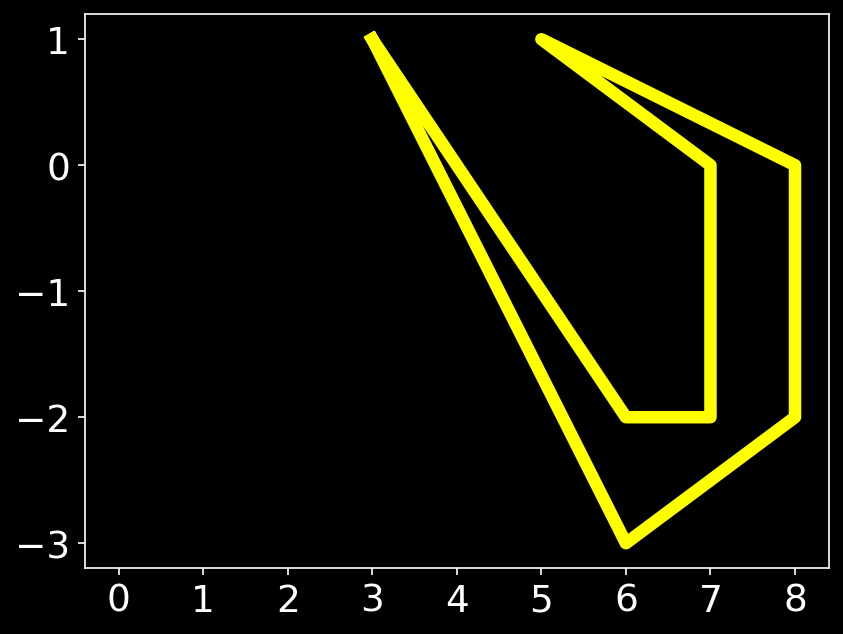

In [62]:
vector_datas = ["""
NCRS1S:
	VEC 0,-2
	VEC 2,-1
	VEC 3,4
	VEC -3,-3
	VEC -1,0
	VEC 0,2
	VEC 2,1
	VEC -3,-1
"""
,"""
NCRS2S:
	VEC 1,-2
	VEC 7,2
	VEC -3,1
	VEC 2,-1
	VEC -6,-1
	VEC 0,1
	VEC 2,1
	VEC -3,-1
"""
,"""
NCRS3S:
	VEC 2,-2
	VEC 6,2
	VEC -3,1
	VEC 2,-1
	VEC -5,-1
	VEC -1,1
	VEC 2,1
	VEC -3,-1
"""
,"""
NCRS4S:
	VEC 3,-2
	VEC 5,2
	VEC -3,1
	VEC 2,-1
	VEC -4,-1
	VEC -2,1
	VEC 2,1
	VEC -3,-1
"""
,"""
NCRS5S:
	VEC 5,-2
	VEC 3,2
	VEC -3,1
	VEC 2,-1
	VEC -2,-1
	VEC -4,1
	VEC 2,1
	VEC -3,-1
"""
,"""
NCRS6S:
	VEC 6,-2
	VEC 2,2
	VEC -3,1
	VEC 2,-1
	VEC -1,-1
	VEC -5,1
	VEC 2,1
	VEC -3,-1
"""
,"""
NCRS7S:
	VEC 7,-2
	VEC 1,2
	VEC -3,1
	VEC 2,-1
	VEC 0,-1
	VEC -6,1
	VEC 2,1
	VEC -3,-1
"""
,"""
NCRS8S:
	VEC 3,1,0
	VEC 3,-4
	VEC 2,1
	VEC 0,2
	VEC -3,1
	VEC 2,-1
	VEC 0,-2
	VEC -1,0
	VEC -3,3
"""
]

plt.style.use('dark_background')
plt.rcParams['figure.dpi'] = 150

def plot_all_vertices(verts,mins_maxes,file_name_suffix,linewidth=6.0,points=""):
    # Plot a series of vertices onto a graph. In other words,
    # create an image from them.
    _, ax = plt.subplots()
    min_x,max_x,min_y,max_y = mins_maxes
    last_x,last_y=[],[]
    for k,g in groupby(verts, key=itemgetter(2)):
        l = list(g)
        xs,ys,_ =zip(*l)
        # Don't paint the vectors marked as black, 
        # we're just moving the beam.
        alpha = 0 if k == "BLACK" else 1
        ax.plot(xs,ys,points+'-',color=k,alpha=alpha,linewidth=linewidth)
    ax.dataLim.y0 = min_y
    ax.dataLim.y1 = max_y
    ax.dataLim.x0 = min_x
    ax.dataLim.x1 = max_x
    ax.set_yticks(range(min_y,max_y+1))
    ax.set_xticks(range(min_x,max_x+1))
    ax.tick_params(axis='both', which='major', labelsize=linewidth*3)
    plt.savefig(f"cursors/final_cursor_{file_name_suffix}.png", bbox_inches='tight')

for i, vector_data in enumerate(vector_datas):
    vectors = parse_vector_commands(vector_data,default_color="yellow")
    vertices = vectors_to_coords(vectors)
    max_x = max([x for x,_,_ in vertices])
    min_x = min([x for x,_,_ in vertices])
    max_y = max([y for _,y,_ in vertices])
    min_y = min([y for _,y,_ in vertices])
    mins_maxes = (min_x,max_x,min_y,max_y)

    plot_all_vertices(vertices,mins_maxes,f"{i}")
